## Imports

In [1]:
from constants import FLUXES_FOLDER, SLM_FOLDER

from data_utils import process_amp_phase_data

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_fully_connected_amp_phase_prediction, \
                       plot_conv_amp_phase_prediction

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           create_convolutional_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           store_model

from configurations import SimpleConvolutional as ModelConfiguration

2023-12-10 20:21:44.782932: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 20:21:44.860271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 20:21:44.860295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 20:21:44.861823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 20:21:44.885254: I tensorflow/core/platform/cpu_feature_guar

## Load data

In the first place, define the data paths

In [2]:
train_fluxes_array, val_fluxes_array, train_amp_phase_array, val_amp_phase_array, scalers = \
    process_amp_phase_data(
        n_points=30000,
        normalize_flux=True,
        normalize_amplitude=True,
        shuffle=False,
        flatten_fluxes=False,
        split=True,
        val_ratio=0.1
    )

In [3]:
train_fluxes_array.shape

(27000, 55, 24)

In [4]:
val_fluxes_array.shape

(3000, 55, 24)

In [5]:
train_amp_phase_array.shape

(27000, 2, 96, 96)

In [6]:
val_amp_phase_array.shape

(3000, 2, 96, 96)

## CONVOLUTIONAL MODEL

In [7]:
model_configuration = ModelConfiguration(train_fluxes_array,
                                         train_amp_phase_array)
print(model_configuration.get_description())


	=== SimpleConvolutional ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Convolutional
		-Input shape: (55, 24)
		-Output shape: (2, 96, 96)
		-Convolutional Layers: [128, 256, 512]
		-Convolutonal Kernels: [(3, 3), (3, 3), (3, 3)]
		-Fully Connected Hidden layers: [1024, 2048, 2048, 2048]
		-Regularizer: None
		-Convolutional Activation: relu
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: True
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.0001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 200
		-Batch size: 32
		-Callbacks:
			-ReduceLROnPlateau: MSE 15 x0.1
			-Early Stop: MSE 50
	


2023-12-10 20:22:09.713563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 20:22:09.796895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 20:22:09.797058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
model = create_convolutional_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

Model: "SimpleConvolutional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 53, 22, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 11, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 9, 256)        295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 4, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 2, 512)        1180160   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 1, 512) 

In [9]:
history = train_model(
    model,
    train_fluxes_array,
    train_amp_phase_array,
    val_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/200


2023-12-10 20:22:13.439532: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-10 20:22:13.561007: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 20:22:13.926495: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 20:22:14.254275: I external/local_xla/xla/service/service.cc:168] XLA service 0x899d6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 20:22:14.254292: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-10 20:22:14.266549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702200134.356182   58073 device_com

844/844 [==============================] - 21s 20ms/step - loss: 0.5097 - mean_squared_error: 0.5097 - val_loss: 0.4568 - val_mean_squared_error: 0.4568 - lr: 1.0000e-04
Epoch 2/200
844/844 [==============================] - 17s 20ms/step - loss: 0.4150 - mean_squared_error: 0.4150 - val_loss: 0.4493 - val_mean_squared_error: 0.4493 - lr: 1.0000e-04
Epoch 3/200
844/844 [==============================] - 16s 19ms/step - loss: 0.3754 - mean_squared_error: 0.3754 - val_loss: 0.4853 - val_mean_squared_error: 0.4853 - lr: 1.0000e-04
Epoch 4/200
844/844 [==============================] - 16s 19ms/step - loss: 0.3473 - mean_squared_error: 0.3473 - val_loss: 0.3813 - val_mean_squared_error: 0.3813 - lr: 1.0000e-04
Epoch 5/200
844/844 [==============================] - 16s 19ms/step - loss: 0.3264 - mean_squared_error: 0.3264 - val_loss: 0.3701 - val_mean_squared_error: 0.3701 - lr: 1.0000e-04
Epoch 6/200
844/844 [==============================] - 16s 19ms/step - loss: 0.3120 - mean_squared_err

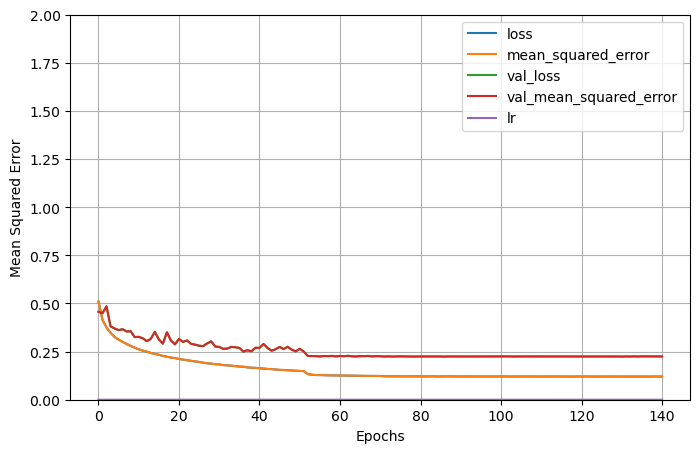

In [10]:
plot_model_history(history)

1/1 [==============================] - 0s 161ms/step


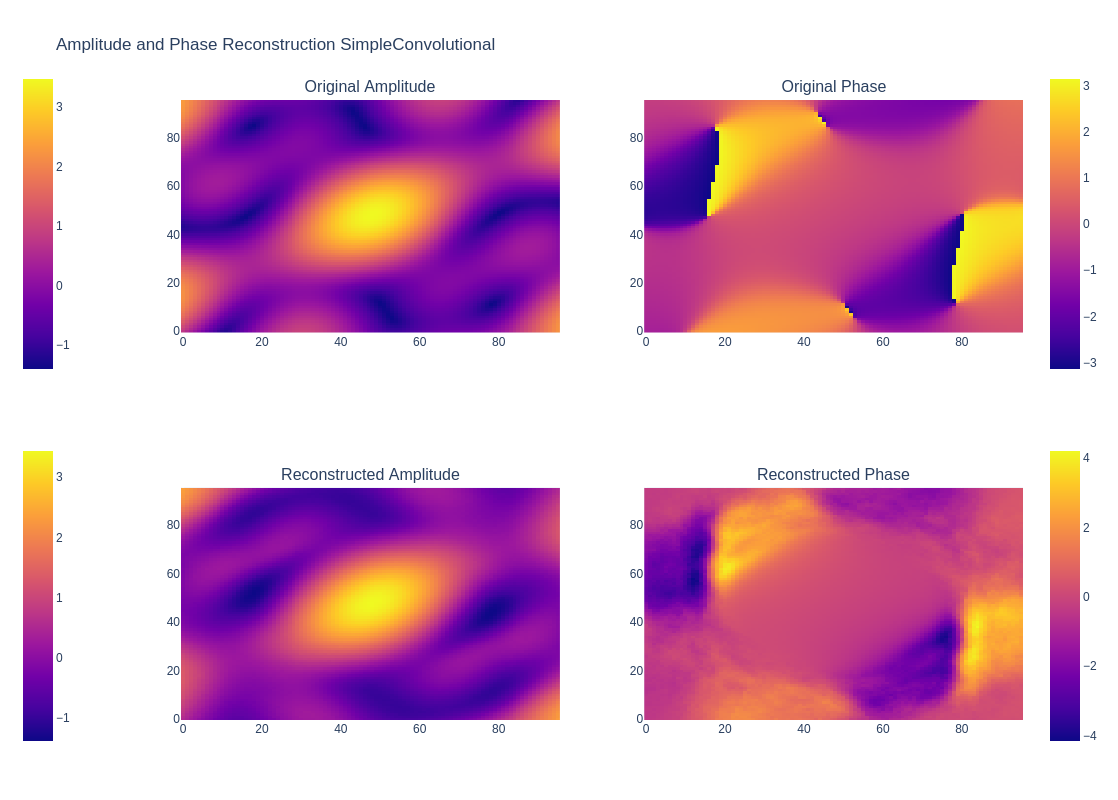

In [11]:
n = 106
plot_conv_amp_phase_prediction(
    model,
    val_fluxes_array[n],
    val_amp_phase_array[n][0],
    val_amp_phase_array[n][1]
    )

1/1 [==============================] - 0s 14ms/step


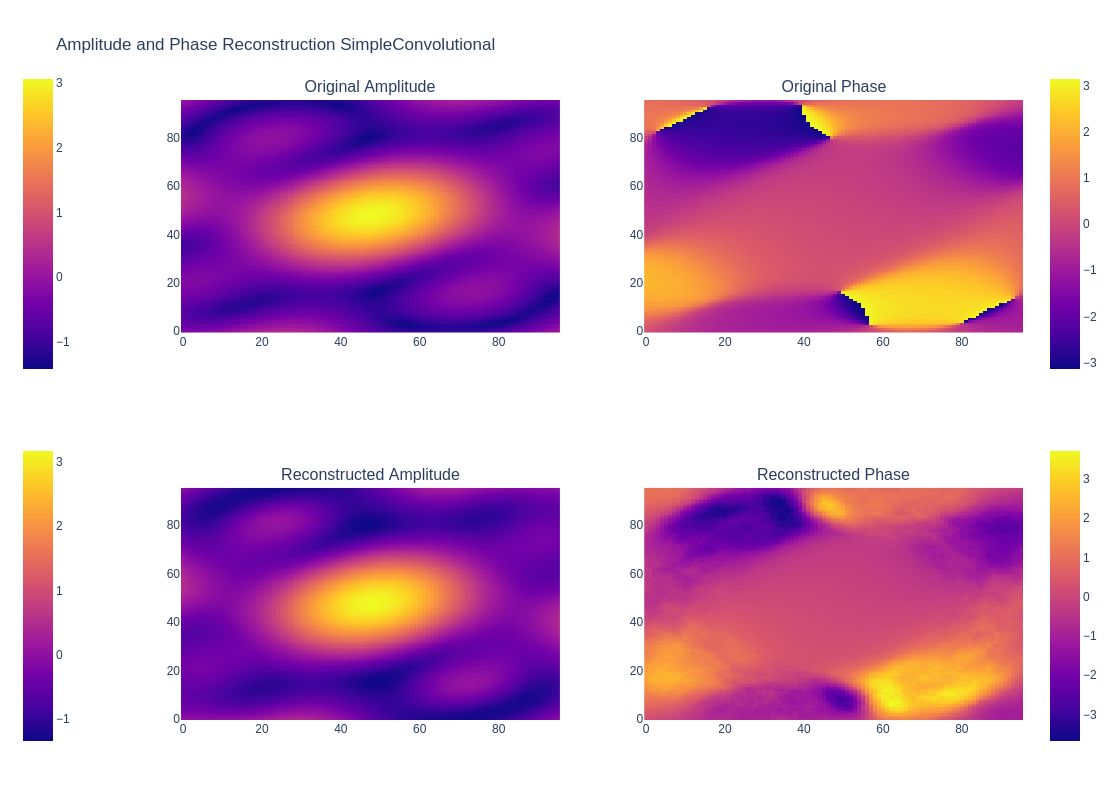

In [12]:
n = 106
plot_conv_amp_phase_prediction(
    model,
    train_fluxes_array[n],
    train_amp_phase_array[n][0],
    train_amp_phase_array[n][1]
    )

In [14]:
store_model(model,
            model.name,
            model_configuration.get_description())